Importing the libraries

In [1]:
import sklearn
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn import preprocessing
import numpy as np

Read data file

In [2]:
df = pd.read_csv("out_without_nan_mood_normalised_extra_temp_train.csv")
clf = LinearRegression()

Add dummies, remove weekDay mean, remove day mean

In [3]:
df['mood_mean_TARGET'] = df['mood_mean_TARGET'].astype(float)
df = pd.concat([df,pd.get_dummies(df['id'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['weekDay'],prefix="day_")],axis=1)
df = df.drop(['weekDay_time_5','day_time_5','weekDay_time_4','day_time_4','weekDay_time_3','day_time_3','weekDay_time_2','day_time_2','weekDay_time_1','day_time_1','weekDay_time_5','mood_mean_time_1','circumplex.valence_mean_time_1'],axis=1)
df = df.fillna(0)
df = df.loc[:, (df != 0).any(axis=0)]

In [4]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr) and corr_matrix.columns[i] != "mood_mean_TARGET" and corr_matrix.columns[j] != "mood_mean_TARGET":
                
                colnameI = corr_matrix.columns[i]
                colnameJ = corr_matrix.columns[j]
                if abs(corr_matrix.mood_mean_TARGET[colnameI]) > abs(corr_matrix.mood_mean_TARGET[colnameJ]):
                    colname = colnameJ
                else:
                    colname = colnameI
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    
    return(dataset)

#correlation(df,0.7) #Won't do this since it isn't actually needed


In [5]:
corr=df.corr()
goodColumns= corr[abs(corr['mood_mean_TARGET'])>=0.25]['mood_mean_TARGET'].sort_values()
goodColumns = goodColumns.drop(['mood_mean_TARGET'])
print(goodColumns)
useThisColumns = goodColumns.keys()

numberOfTimesSeenMood5Days_5   -0.268224
numberOfTimesSeenMood5Days_6   -0.266362
numberOfTimesSeenMood5Days_4   -0.264096
mood_mean                       0.440403
mood_mean_time_3                0.463065
mood_mean_time_4                0.473673
mood_mean_time_2                0.476974
mood_mean_time_5                0.478291
Name: mood_mean_TARGET, dtype: float64


In [6]:
print(useThisColumns)

Index(['numberOfTimesSeenMood5Days_5', 'numberOfTimesSeenMood5Days_6',
       'numberOfTimesSeenMood5Days_4', 'mood_mean', 'mood_mean_time_3',
       'mood_mean_time_4', 'mood_mean_time_2', 'mood_mean_time_5'],
      dtype='object')


In [7]:
notRelevantAll=df.drop(['id','date'],axis=1).dropna()
goldY= notRelevantAll['mood_mean_TARGET']
relevant = notRelevantAll.drop(['mood_mean_TARGET'],axis=1)

In [8]:
scoring = {'R2': 'r2',
           'Mean squared Error': 'neg_mean_squared_error',
           'Explained variance': 'explained_variance'}

scores = cross_validate(clf, relevant[useThisColumns], goldY, cv=7,scoring=scoring)
print("R2: %0.2f (+/- %0.2f)" % (scores['test_R2'].mean(), scores['test_R2'].std() * 2))
print("MSE: %0.2f (+/- %0.2f)" % (scores['test_Mean squared Error'].mean(), scores['test_Mean squared Error'].std() * 2))
print("EXPLAINED VARIANCE: %0.2f (+/- %0.2f)" % (scores['test_Explained variance'].mean(), scores['test_Explained variance'].std() * 2))


R2: 0.17 (+/- 0.30)
MSE: -0.40 (+/- 0.27)
EXPLAINED VARIANCE: 0.19 (+/- 0.30)


Evaluate on real test set

In [9]:
clf.fit(relevant[useThisColumns], goldY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [10]:
dfTest = pd.read_csv("out_without_nan_mood_normalised_extra_temp_test.csv")
dfTest['mood_mean_TARGET'] = dfTest['mood_mean_TARGET'].astype(float)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['id'])],axis=1)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['weekDay'],prefix="day_")],axis=1)

MAE
0.444152996207878
MSE
0.36108093172993655
RMSE
0.6009001012896708
R2
0.3506083496751239
[('numberOfTimesSeenMood5Days_5', -0.09161076178158647), ('numberOfTimesSeenMood5Days_6', -0.3010265554966764), ('numberOfTimesSeenMood5Days_4', -0.237244544923929), ('mood_mean', 0.8415830544942038), ('mood_mean_time_3', -1.840494450451018), ('mood_mean_time_4', 0.37395067512086083), ('mood_mean_time_2', 1.6102968866434988), ('mood_mean_time_5', 1.7788381063247527)]
numberOfTimesSeenMood5Days_5
numberOfTimesSeenMood5Days_6
numberOfTimesSeenMood5Days_4
mood_mean
mood_mean_time_3
mood_mean_time_4
mood_mean_time_2
mood_mean_time_5
-0.09161076178158647
-0.3010265554966764
-0.237244544923929
0.8415830544942038
-1.840494450451018
0.37395067512086083
1.6102968866434988
1.7788381063247527


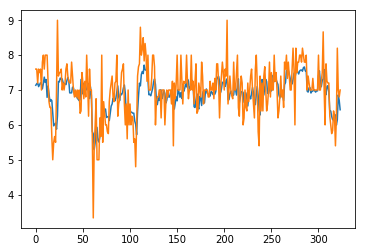

In [17]:
y_pred =clf.predict(dfTest[useThisColumns])
print("MAE")
print(metrics.mean_absolute_error(dfTest['mood_mean_TARGET'],y_pred))
print("MSE")
print(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred))
print("RMSE")
print(np.sqrt(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred)))
print("R2")
print(metrics.r2_score(dfTest['mood_mean_TARGET'],y_pred))


print(list(zip(goodColumns.keys(),clf.coef_)))
for item in goodColumns.keys():
    print(item)
for coef in clf.coef_:
    print(coef)
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(dfTest['mood_mean_TARGET'])
plt.show()


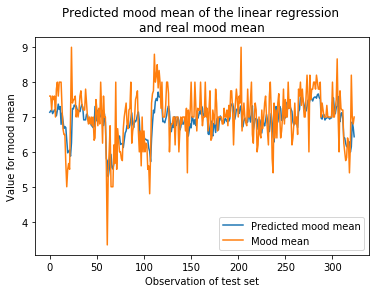

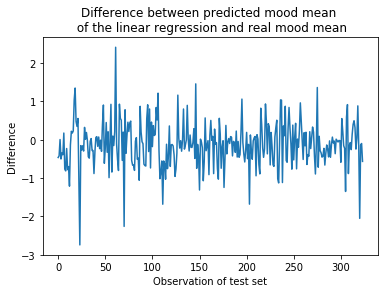

In [12]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(dfTest['mood_mean_TARGET'])
plt.legend(["Predicted mood mean", "Mood mean"])
plt.xlabel('Observation of test set')
plt.ylabel('Value for mood mean')
plt.title('Predicted mood mean of the linear regression \nand real mood mean')
plt.savefig("benchmark_LinearRegression_Both")
plt.show()

plt.plot(y_pred - dfTest['mood_mean_TARGET'])
plt.xlabel('Observation of test set')
plt.ylabel('Difference')
plt.title('Difference between predicted mood mean \n of the linear regression and real mood mean')

plt.savefig("benchmark_LinearRegression_diff")

In [14]:
diff = abs(y_pred-dfTest['mood_mean_TARGET'])
standardDev = diff.std()
mean= diff.mean()
print(standardDev)
print(mean)
clf.coef_

0.405359342366693
0.444152996207878


array([-0.09161076, -0.30102656, -0.23724454,  0.84158305, -1.84049445,
        0.37395068,  1.61029689,  1.77883811])